<a href="https://colab.research.google.com/github/travislatchman/Classify-Pneumonia-in-Chest-X-Rays/blob/main/DataAugmentation_and_Visualization_for_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 we will learn to classify pneumonia using Chest X-Ray dataset which can be downloaded from [here](https://www.dropbox.com/s/cwvaqip12wpex6o/Lab7_XRay_chest_pnemonia.zip?dl=0). This data is already split into train, test and validation directories, so you do not have to split it yourself!  There are two sub-directories under each directory: `NORMAL` and	`PNEUMONIA`

we will learn :
- How to use data augmentation in Pythorch to improve your models
- Visualization using Grad-CAM
- Segmentation





# Part I
Train a Convolutional Neural Network (CNN) with and without data augmentation


In [ ]:
# YOUR IMPORTS HERE
# Note: ALL the imports you use should be here and not in middle of code
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imutils
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score



In [ ]:
!pip install pytorch-gradcam


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


import cv2
from torchvision.utils import make_grid

from gradcam.gradcam import GradCAM
from gradcam.utils import visualize_cam





In [ ]:
!git clone https://github.com/imlab-uiip/lung-segmentation-2d.git

Cloning into 'lung-segmentation-2d'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 54 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (54/54), 55.75 MiB | 10.18 MiB/s, done.


In [ ]:
!pip install keras tensorflow scikit-image SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 29.3 MB/s eta 0:00:00


In [ ]:
!ls /content/lung-segmentation-2d

build_model.py	inference.py  model.png		  trained_model.hdf5
Demo		LICENSE       preprocess_JSRT.py  train_model.py
image_gen.py	load_data.py  README.md


In [ ]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, io, color, exposure, img_as_float, img_as_ubyte, transform
from skimage.transform import resize
import SimpleITK as sitk

## Task 1:
Mount Google Drive  

In [ ]:
# YOUR CODE HERE
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Task 2:
Define directories for train, test, validation

In [ ]:
# YOUR CODE HERE
root_dir = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia"
train_dir = f"{root_dir}/train"
val_dir = f"{root_dir}/val"
test_dir = f"{root_dir}/test"

In [ ]:
root_dir

'/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia'

In [ ]:
train_dir

'/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train'

In [ ]:
root_dir = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia"

if os.path.exists(root_dir):
    print("Directory exists!")
else:
    print("Directory does not exist!")


Directory exists!


## Task 3:
Task 3.1: Visualize four normal images and four Pneumonia images from train set.

Task 3.2: Plot class distribution of all sets using bar plots. Is the training set balanced? If not, please change your loss function to conpensate it. \

In [ ]:
def visualize_images(img_dir, title, num_images=4):

  for i in range(num_images):
    plt.figure(figsize=(10, 5))
    img_path = os.path.join(img_dir, os.listdir(img_dir)[i])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

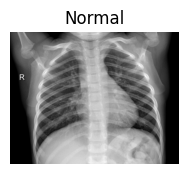

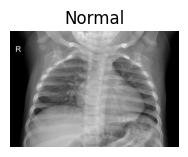

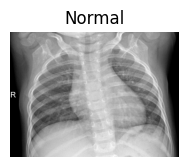

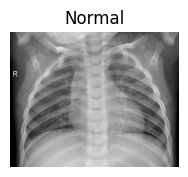

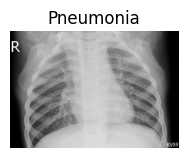

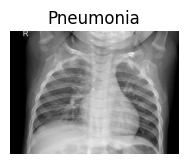

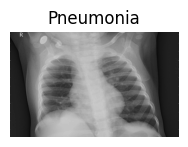

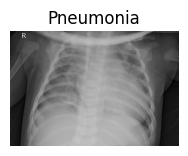

In [ ]:
normal_train_dir = os.path.join(train_dir, "NORMAL")
pneumonia_train_dir = os.path.join(train_dir, "PNEUMONIA")

visualize_images(normal_train_dir, "Normal")
visualize_images(pneumonia_train_dir, "Pneumonia")

In [ ]:
def class_distribution(data_dir, title):
  normal_count = len(os.listdir(os.path.join(data_dir, "NORMAL")))
  pneumonia_count = len(os.listdir(os.path.join(data_dir, "PNEUMONIA")))
  sns.barplot(x=["Normal", "Pneumonia"], y=[normal_count, pneumonia_count])
  plt.title(title)
  plt.show()

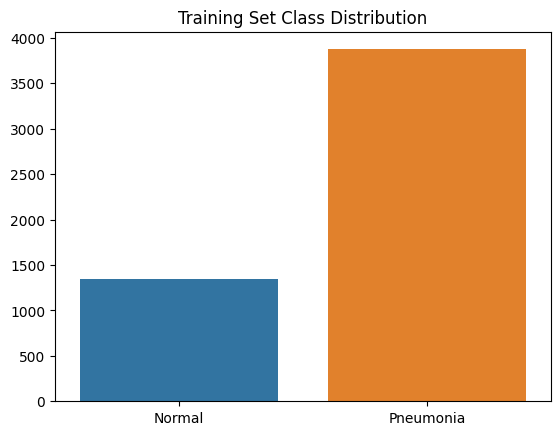

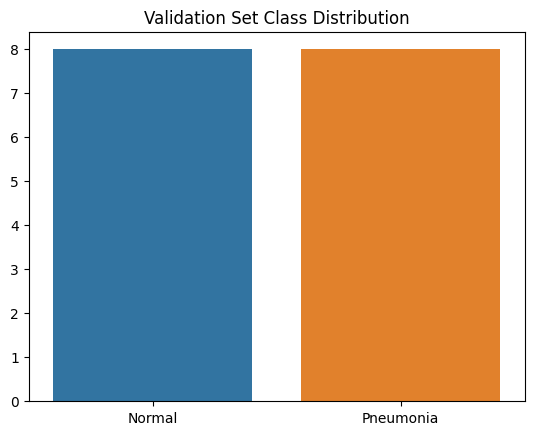

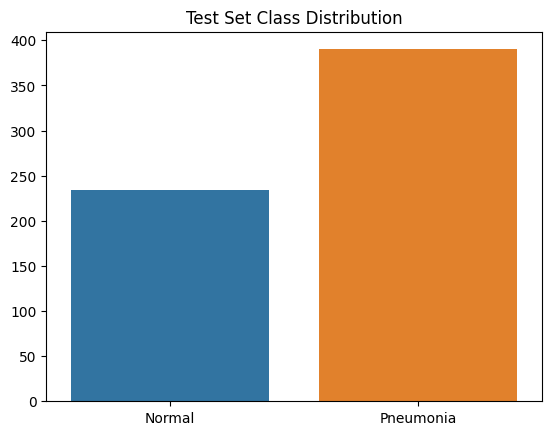

In [ ]:
class_distribution(train_dir, "Training Set Class Distribution")
class_distribution(val_dir, "Validation Set Class Distribution")
class_distribution(test_dir, "Test Set Class Distribution")

## Task 4:
Train a Convolutional Neural Network (CNN) using data loaders. **Plot training and validation accuracy and loss in a graph.** Please report the recall-rate, precision, accuracy and F1-score on test set.



In [ ]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# Create datasets and data loaders
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:

# Initialize the model, optimizer, and criterion
model = SimpleCNN().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc

In [ ]:
# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc

In [ ]:
# Compute class weights
normal_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
pneumonia_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))
total_count = normal_count + pneumonia_count
class_weights = torch.tensor([total_count / normal_count, total_count / pneumonia_count])

# Use the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights.to('cuda'))

Epoch 1/10, Train Loss: 0.4386, Train Acc: 0.8735, Val Loss: 0.4099, Val Acc: 0.7500
Epoch 2/10, Train Loss: 0.1499, Train Acc: 0.9410, Val Loss: 0.7547, Val Acc: 0.6875
Epoch 3/10, Train Loss: 0.1123, Train Acc: 0.9580, Val Loss: 0.9800, Val Acc: 0.6875
Epoch 4/10, Train Loss: 0.0721, Train Acc: 0.9741, Val Loss: 1.1802, Val Acc: 0.8125
Epoch 5/10, Train Loss: 0.0501, Train Acc: 0.9806, Val Loss: 1.0909, Val Acc: 0.7500
Epoch 6/10, Train Loss: 0.0354, Train Acc: 0.9875, Val Loss: 1.4780, Val Acc: 0.8125
Epoch 7/10, Train Loss: 0.0178, Train Acc: 0.9939, Val Loss: 1.2173, Val Acc: 0.8750
Epoch 8/10, Train Loss: 0.0187, Train Acc: 0.9925, Val Loss: 1.4254, Val Acc: 0.6875
Epoch 9/10, Train Loss: 0.0169, Train Acc: 0.9935, Val Loss: 1.9352, Val Acc: 0.7500
Epoch 10/10, Train Loss: 0.0073, Train Acc: 0.9979, Val Loss: 1.4933, Val Acc: 0.8125


TypeError: ignored

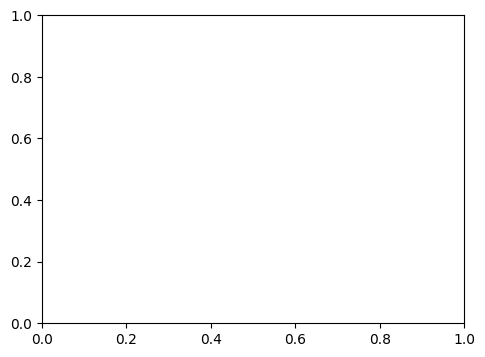

In [ ]:
# Train and validate the model
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, 'cuda')
    val_loss, val_acc = validate(model, val_loader, criterion, 'cuda')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# # Plot the training and validation accuracy and loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Evaluate the model on the test set
# test_loss, test_acc = validate(model, test_loader, criterion, 'cuda')
# print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


PLEASE DON'T PAY ATTENTION TO THE ERROR AND BLANK GRAPH ABOVE AFTER TRAINING AND VALIDATION. I FIXED THE ERROR IN THE NEXT CELL SO I WOULDN'T HAVE TO TRAIN AGAIN, WHICH TOOK 27 MINUTES!

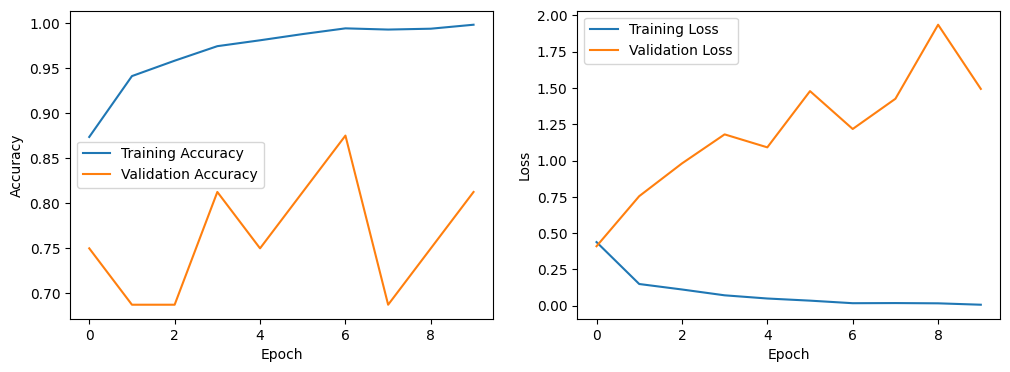

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([acc.item() for acc in train_accuracies], label='Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Calculate recall, precision, accuracy, and F1-score
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print(f"Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}, F1-score: {f1_score:.4f}")

Recall: 0.9897, Precision: 0.7215, Accuracy: 0.7548, F1-score: 0.8346


## Task 5:
Use data-augmentation inbuilt in Pythorch wisely. Keep all model parameters same as Task 3 for comparison.

> ⏩ Hint: Data augmentation in Pytorch is very simple when using dataloader. Please carefully select the augmentation parameters in `transforms.Compose`. You may want to refer to https://pytorch.org/vision/stable/transforms.html for options available.

> Then train a Convolutional Neural Network (CNN) with the same parameters as Task 3. **Plot training and validation accuracy and loss in a graph.** Please report the recall-rate, precision, accuracy and F1-score on test set.

🔷 Some augmentation parameters may not be suitable in this lab. Please write in comments why are you using those paramters for augmentation of X-Rays. If you do not write these comments, points will be deducted.

In [ ]:
# YOUR CODE HERE

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-10, 10)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transforms.RandomHorizontalFlip() flips the image horizontally with a 50% probability. This can help the model generalize better to unseen data by simulating the variation in the position of the lungs and heart.

transforms.RandomRotation((-10, 10)) rotates the image by a random angle in the range of (-10, 10) degrees. This introduces invariance to slight rotations and captures different perspectives of the chest X-rays.

transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)) applies a random affine transformation to the image. The translation and scaling parameters help the model generalize to images with varying sizes and positions of the lungs.

In [ ]:
# Create datasets and data loaders
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:

# Initialize the model, optimizer, and criterion
model = SimpleCNN().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Compute class weights
normal_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
pneumonia_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))
total_count = normal_count + pneumonia_count
class_weights = torch.tensor([total_count / normal_count, total_count / pneumonia_count])

# Use the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights.to('cuda'))

In [ ]:
# Train and validate the model
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, 'cuda')
    val_loss, val_acc = validate(model, val_loader, criterion, 'cuda')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10, Train Loss: 0.7941, Train Acc: 0.6143, Val Loss: 0.8054, Val Acc: 0.7500
Epoch 2/10, Train Loss: 0.2515, Train Acc: 0.9015, Val Loss: 1.2915, Val Acc: 0.5625
Epoch 3/10, Train Loss: 0.2237, Train Acc: 0.9110, Val Loss: 0.9974, Val Acc: 0.6875
Epoch 4/10, Train Loss: 0.2028, Train Acc: 0.9222, Val Loss: 1.2367, Val Acc: 0.5000
Epoch 5/10, Train Loss: 0.1892, Train Acc: 0.9266, Val Loss: 0.5908, Val Acc: 0.7500
Epoch 6/10, Train Loss: 0.1753, Train Acc: 0.9354, Val Loss: 0.9699, Val Acc: 0.6250
Epoch 7/10, Train Loss: 0.1745, Train Acc: 0.9339, Val Loss: 1.4090, Val Acc: 0.6250
Epoch 8/10, Train Loss: 0.1586, Train Acc: 0.9419, Val Loss: 1.1031, Val Acc: 0.6250
Epoch 9/10, Train Loss: 0.1624, Train Acc: 0.9398, Val Loss: 0.5745, Val Acc: 0.6875
Epoch 10/10, Train Loss: 0.1606, Train Acc: 0.9352, Val Loss: 0.5060, Val Acc: 0.6875


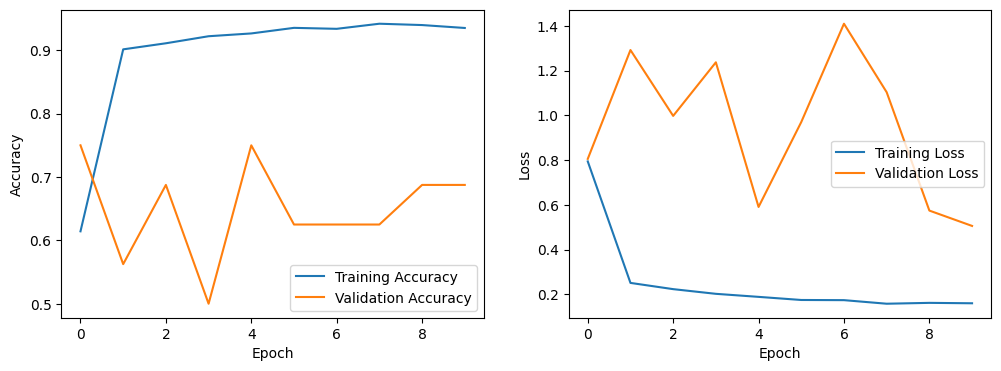

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([acc.item() for acc in train_accuracies], label='Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Calculate recall, precision, accuracy, and F1-score
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print(f"Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}, F1-score: {f1_score:.4f}")

Recall: 0.9615, Precision: 0.8315, Accuracy: 0.8542, F1-score: 0.8918


## Task 6:
Compare results with and without data augmentation. Did data augmentation help improving f-score? Why do you think it worked/not worked? Display nine examples of augmented data from training set.

### Results without augmentation
Recall: 0.9897, Precision: 0.7215, Accuracy: 0.7548, F1-score: 0.8346

### Results with augmentation
Recall: 0.9615, Precision: 0.8315, Accuracy: 0.8542, F1-score: 0.8918

Comparing the results with and without data augmentation,  data augmentation has helped improve the performance of the model, particularly in terms of F1-score, precision, and accuracy.

The recall is slightly lower with data augmentation, but the precision, accuracy, and F1-score have significantly improved. This shows that the model has become more balanced in terms of its ability to correctly identify both positive and negative cases.

Data augmentation helped the model generalize better by introducing variability in the training data. By creating modified versions of the original images (e.g., through rotation, scaling, flipping, etc.), the model learns to recognize patterns and features that are invariant to these transformations. This leads to a more robust model that is better equipped to handle variations in the test data.

In [ ]:
# Create a new dataset with the data augmentation transforms
augmented_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Create a DataLoader with a batch size of 9
augmented_loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=9, shuffle=True)

# Get a batch of 9 images and labels
images, labels = next(iter(augmented_loader))




In [ ]:
# Define a helper function for unnormalizing images
def unnormalize(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img



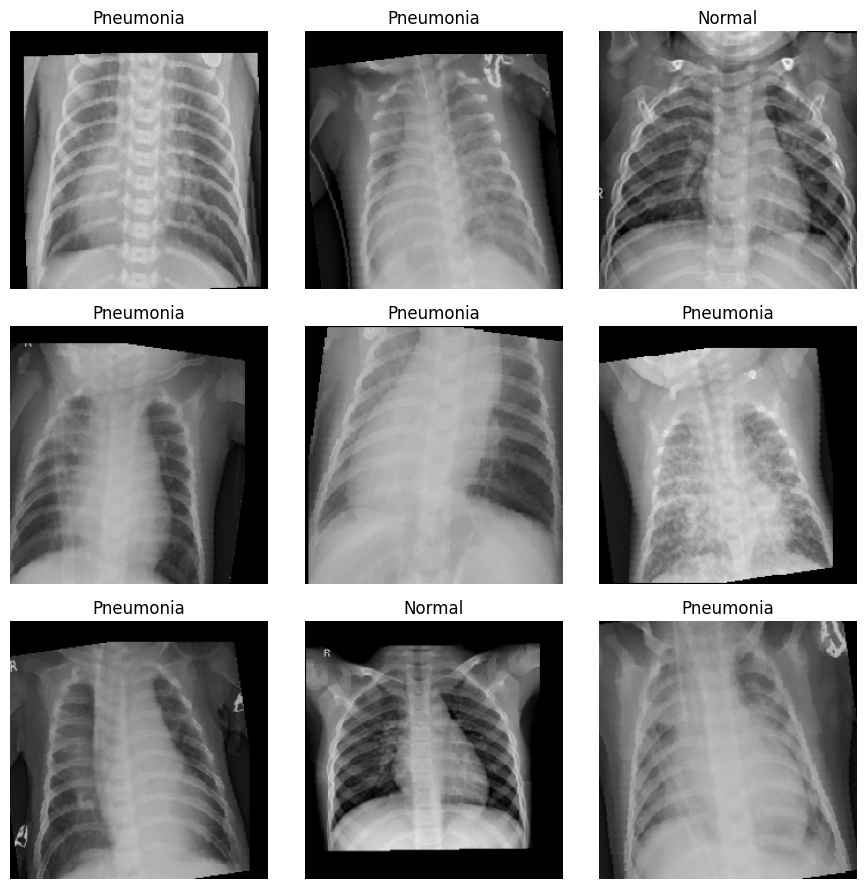

In [ ]:
# Plot the 9 augmented images
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(unnormalize(images[i]))
    ax.set_title('Pneumonia' if labels[i].item() else 'Normal')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Part II
Visualization using Grad-CAM.



## Task 7:
What is Grad-CAM? Why do you think Grad-CAM is useful?
Please give a short summary of Grad-CAM (100-200 words)

You may want to read the paper here : https://arxiv.org/abs/1610.02391

Grad-CAM (Gradient-weighted Class Activation Mapping) is a visualization technique for understanding the decisions made by convolutional neural networks (CNNs) in image classification tasks. It provides insight into which regions of the input image contribute the most to the model's prediction by generating a coarse localization map that highlights the important areas in the image. Grad-CAM can be applied to any CNN architecture without the need for architectural modifications or retraining.

Grad-CAM works by computing the gradients of the predicted class score with respect to the feature maps of the last convolutional layer. These gradients are then used to compute a weighted sum of the feature maps, resulting in a class activation map. The class activation map is then upsampled to the size of the input image to produce a heatmap that highlights the regions in the image that the model finds most relevant for the predicted class.

Grad-CAM is useful because it helps to understand and interpret the predictions made by complex CNN models. By visualizing the important regions in the input image, Grad-CAM can provide insights into the model's decision-making process, which can be helpful for model debugging, identifying biases, and improving the model's performance. Additionally, Grad-CAM can be used to generate weak localization information for tasks like object detection and semantic segmentation, where ground truth bounding boxes or segmentation masks may not be available.

## Task 8:

Visualize 4 samples in test data (true positive, false positive, true negative, and false negative each) using Grad-CAM. For every data points, you plot the Grad-CAM image and also mention the predicted and true labels. <br>

Feel free to use any open-source implementation or existing lib, but **remember to explain clearly what each part of the code is doing** and cite the link you used the code from. If you do not write appropriate comments and give appropriate credits to original author, points will be deducted.

pytorch-grad-cam library to visualize Grad-CAM samples. library here: https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
# Function to find a sample of each type (TP, FP, TN, FN)
def find_samples(model, dataloader, device):
    true_positive, false_positive, true_negative, false_negative = None, None, None, None

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if true_positive is None and labels[i] == 1 and preds[i] == 1:
                true_positive = (images[i], labels[i], preds[i])
            elif false_positive is None and labels[i] == 0 and preds[i] == 1:
                false_positive = (images[i], labels[i], preds[i])
            elif true_negative is None and labels[i] == 0 and preds[i] == 0:
                true_negative = (images[i], labels[i], preds[i])
            elif false_negative is None and labels[i] == 1 and preds[i] == 0:
                false_negative = (images[i], labels[i], preds[i])

            if true_positive and false_positive and true_negative and false_negative:
                break

        if true_positive and false_positive and true_negative and false_negative:
            break

    return true_positive, false_positive, true_negative, false_negative

In [ ]:
# Display function
def display_gradcam(sample, category):
    image, true_label = sample
    image = image.unsqueeze(0).to(device)

    output = model(image)
    _, pred_label = torch.max(output.data, 1)
    pred_label_name = class_labels[pred_label.cpu().item()]

    print(f"Predicted: {pred_label_name}, True: {class_labels[true_label]}, Category: {category}")

    cam = grad_cam(input_tensor=image.to(device))

    cam = cam[0]
    cam = np.uint8(255 * cam)

    colormap = cv2.COLORMAP_JET
    heatmap = cv2.applyColorMap(cam, colormap)

    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    images_np = image.permute(0, 2, 3, 1).cpu().numpy()
    result = heatmap * images_np + (1 - images_np) * 255
    result = np.uint8(result)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(image[0].permute(1, 2, 0).cpu())
    ax[0].set_title(f"Original Image ({class_labels[true_label]})")
    ax[0].axis("off")
    ax[1].imshow(result[0])
    ax[1].set_title(f"Heatmap")
    ax[1].axis("off")
    fig.suptitle(category)
    plt.show()

Predicted: Normal, True: Pneumonia, Category: True Positive


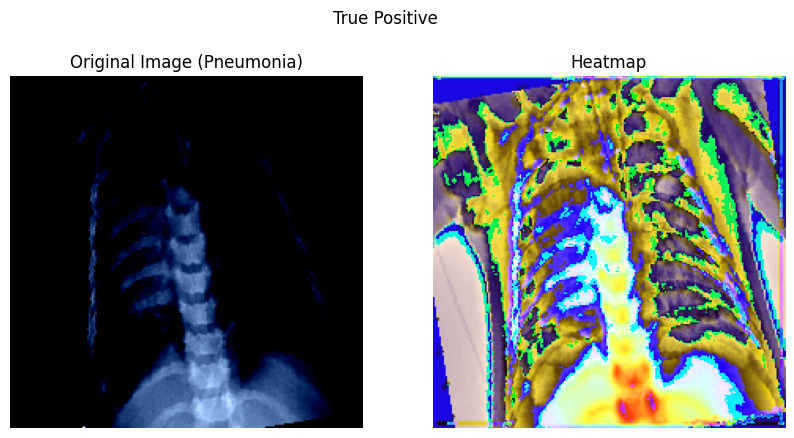

Predicted: Normal, True: Normal, Category: False Positive


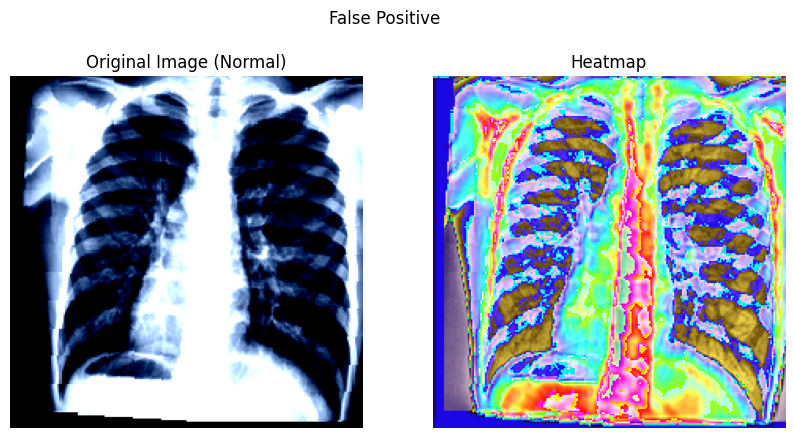

Predicted: Normal, True: Normal, Category: True Negative


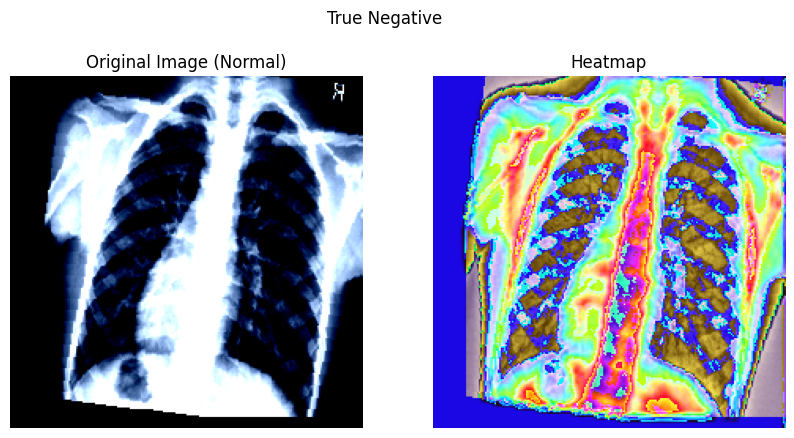

Predicted: Normal, True: Pneumonia, Category: False Negative


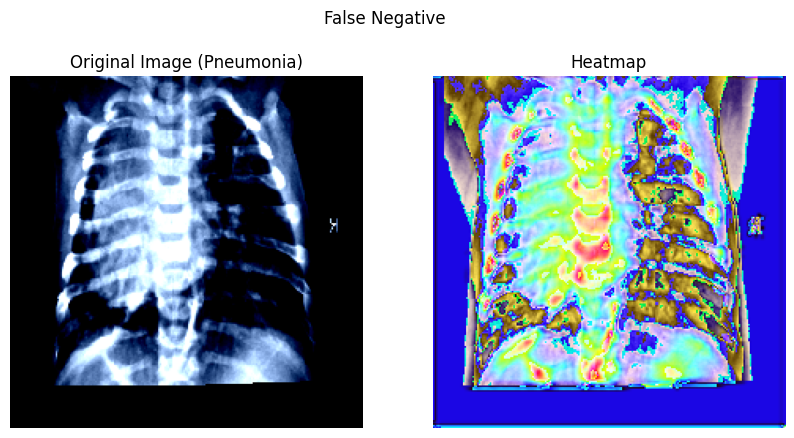

In [ ]:
# Load model and its weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleCNN().to(device)

# Define class labels
class_labels = ['Normal', 'Pneumonia']

# Find the samples
true_positive, false_positive, true_negative, false_negative = find_samples(model, test_loader, 'cuda')

# Initialize the GradCAM object
grad_cam = GradCAM(model=model, target_layers=[model.conv2])

# Prepare the samples and categories
tp_sample = (true_positive[0], true_positive[1]), (false_positive[0], false_positive[1]), (true_negative[0], true_negative[1]), (false_negative[0], false_negative[1])
categories = ["True Positive", "False Positive", "True Negative", "False Negative"]

# Display Grad-CAM images
for i in range(len(tp_sample)):
    display_gradcam(tp_sample[i], categories[i])


# Part III

Lung segmentation and transfer learning

## Task 9:

Use lung segmentation as pre-processing to see if such processing helps your models. After doing lung segmentation, you will discard certain irrelevant information such as part of the skeleton, the heart, etc. Display four samples from training set to show the result of segmentations.
<br>

You can use this for segmentation: https://github.com/imlab-uiip/lung-segmentation-2d

You can also check this: https://github.com/jdariasl/COVIDNET from this paper: https://ieeexplore.ieee.org/abstract/document/9293268

**Hint 1:** In this task you need the keras.models.load_model to load the model from https://github.com/imlab-uiip/lung-segmentation-2d

**Hint 2:**You need to follow the preprocessing method in their code to segment the images, or the results will not be good.

**Hint 3:** Make a new folder and save the segmentations for task 10.

In [ ]:
UNet = load_model("/content/lung-segmentation-2d/trained_model.hdf5")


In [ ]:
# root_dir = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia"
# train_dir = f"{root_dir}/train"


In [ ]:
# adapt function from DEMO.PY
def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img


In [ ]:
def loadDataGeneral(path, im_shape):
    _, file_extension = os.path.splitext(path)
    file_extension = file_extension.lower()

    reader = sitk.ImageFileReader()
    if file_extension == '.png':
        reader.SetImageIO("PNGImageIO")
    elif file_extension == '.jpg' or file_extension == '.jpeg':
        reader.SetImageIO("JPEGImageIO")
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")

    reader.SetFileName(path)
    image = reader.Execute()
    image = sitk.GetArrayFromImage(image)
    img = img_as_float(image)
    img = resize(img, im_shape)
    img = exposure.equalize_hist(img)
    img = np.expand_dims(img, -1)
    return img, image


In [ ]:
img_shape=(256,256)

In [ ]:
!pip install tensorflow==2.6.0
!pip install keras==2.6.0



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# TRAIN - NORMAL SEGMENTED

In [ ]:


# Load images, perform segmentation, and save the segmented images
paths = glob.glob(train_dir + '/NORMAL/*')
#segmented_paths = []  # Store the paths of the saved segmented images

for i, path in enumerate(paths):
    X, img_org = loadDataGeneral(path, img_shape)
    img = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
    img_resized = resize(img, (256, 256), anti_aliasing=True)
    pred = UNet.predict(np.expand_dims(img_resized, axis=-1)[None, ...])
    pr = pred > 0.5
    pr = remove_small_regions(pr, 0.02 * np.prod(img_shape))
    pr_changed = np.expand_dims((np.squeeze(pr)), -1)
    img_org_resized = resize(img_org, (256, 256), anti_aliasing=True)
    img_org_resized = img_org_resized[..., None]  # Add an additional dimension to img_org_resized
    segmented = np.squeeze(img_org_resized * pr_changed)
    save_path = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/NORMAL_SEGMENTED/" + paths[i].rpartition('/')[-1]
    io.imsave(save_path, img_as_ubyte(segmented))
    #segmented_paths.append(save_path)


<ipython-input-65-b4985ed466c0>:19: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/NORMAL_SEGMENTED/NORMAL2-IM-0725-0001.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-65-b4985ed466c0>:19: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/NORMAL_SEGMENTED/NORMAL2-IM-0757-0001.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-65-b4985ed466c0>:19: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/NORMAL_SEGMENTED/NORMAL2-IM-1356-0001.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-65-b4985ed466c0>:19: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/NORMAL_SEGMENTED/NORMAL2-IM-1396-0001.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


# TRAIN - PNEUMONIA SEGMENTED

### this gave me a problem only with train - pneumonia segmented, had to reimplement with a try-except block and leave out images that would not segment (didn't have this trouble with other folders)

### pneuomoia train try-except block

In [ ]:
# Load images, perform segmentation, and save the segmented images
paths = glob.glob(train_dir + '/PNEUMONIA/*')

for i, path in enumerate(paths):
    X, img_org = loadDataGeneral(path, img_shape)
    img = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
    img_resized = resize(img, (256, 256), anti_aliasing=True)

    try:
        pred = UNet.predict(np.expand_dims(img_resized, axis=-1)[None, ...])
        pr = pred > 0.5
        pr = remove_small_regions(pr, 0.02 * np.prod(img_shape))
        pr_changed = np.expand_dims((np.squeeze(pr)), -1)
        img_org_resized = resize(img_org, (256, 256), anti_aliasing=True)
        img_org_resized = img_org_resized[..., None]  # Add an additional dimension to img_org_resized
        segmented = np.squeeze(img_org_resized * pr_changed)
        save_path = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/" + paths[i].rpartition('/')[-1]
        io.imsave(save_path, img_as_ubyte(segmented))
    except Exception as e:
        print(f"Skipping image {paths[i].rpartition('/')[-1]} due to error: {str(e)}")


<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person552_bacteria_2315.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person600_bacteria_2457.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person532_virus_1054.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person554_bacteria_2322.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person545_virus_1081.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person563_bacteria_2339.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person55_bacteria_260.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person533_bacteria_2245.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person586_bacteria_2417.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person551_bacteria_2311.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person529_bacteria_2228.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person531_bacteria_2237.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person592_bacteria_2431.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person547_bacteria_2296.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person547_bacteria_2292.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person536_virus_1064.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person588_bacteria_2422.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person600_virus_1156.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person596_bacteria_2443.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person568_bacteria_2359.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person531_bacteria_2238.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person526_bacteria_2221.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person539_bacteria_2270.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person543_bacteria_2280.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person536_virus_1065.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person529_bacteria_2229.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person571_virus_1114.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person58_bacteria_272.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person581_bacteria_2400.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person5_bacteria_17.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person585_bacteria_2413.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person557_bacteria_2327.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person563_bacteria_2340.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person592_virus_1141.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person530_bacteria_2233.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person582_bacteria_2405.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person548_bacteria_2302.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person528_bacteria_2227.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person598_virus_1151.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person563_bacteria_2334.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person541_bacteria_2274.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person548_bacteria_2299.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person59_bacteria_282.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-

Skipping image person547_bacteria_2294.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person597_bacteria_2451.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person543_bacteria_2281.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person581_bacteria_2393.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person565_bacteria_2348.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person718_virus_1316.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person663_virus_1248.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person684_virus_1275.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person680_bacteria_2575.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person719_bacteria_2621.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person656_bacteria_2548.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person64_bacteria_319.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person665_virus_1250.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person625_bacteria_2499.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person669_bacteria_2561.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person673_bacteria_2566.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-8

Skipping image person630_virus_1209.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person629_bacteria_2506.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person70_bacteria_342.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person688_virus_1282.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person714_bacteria_2615.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person670_virus_1256.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person692_virus_1286.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person726_bacteria_2628.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person632_bacteria_2521.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person684_bacteria_2580.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person675_bacteria_2569.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person629_bacteria_2507.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person67_bacteria_330.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person666_virus_1251.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person670_virus_1259.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person67_bacteria_328.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person712_virus_1310.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person64_bacteria_316.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person707_bacteria_2606.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person608_bacteria_2473.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person720_virus_1339.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person71_bacteria_347.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e

Skipping image person709_bacteria_2608.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person691_bacteria_2588.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person719_virus_1338.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person625_bacteria_2500.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person669_bacteria_2562.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person64_bacteria_317.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person658_bacteria_2550.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person728_bacteria_2630.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person669_virus_1255.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person647_virus_1229.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person724_bacteria_2626.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person663_virus_1247.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person65_bacteria_322.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person724_virus_1344.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person61_bacteria_293.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person671_bacteria_2564.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person621_virus_1194.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person605_bacteria_2466.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person626_bacteria_2502.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person67_bacteria_329.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person612_bacteria_2477.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person629_bacteria_2509.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person660_virus_1244.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person688_virus_1281.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person696_bacteria_2594.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person64_bacteria_320.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person721_bacteria_2623.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person608_bacteria_2472.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person653_bacteria_2545.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person672_bacteria_2565.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-7

Skipping image person795_virus_1427.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person745_virus_1368.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person88_virus_161.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person843_virus_1485.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person778_bacteria_2682.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person760_virus_1388.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person826_virus_1462.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person849_bacteria_2770.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person741_bacteria_2644.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person768_virus_1396.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person73_bacteria_359.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person7_bacteria_24.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person773_virus_1402.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person841_bacteria_2760.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d

Skipping image person819_virus_1455.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person888_bacteria_2812.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person749_virus_1374.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person800_bacteria_2706.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person883_bacteria_2807.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person751_bacteria_2654.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person826_bacteria_2737.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person858_bacteria_2780.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person770_virus_1398.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person746_virus_1369.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person742_virus_1365.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person783_bacteria_2687.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person850_bacteria_2771.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person847_bacteria_2767.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-8

Skipping image person832_virus_1468.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person770_bacteria_2674.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person817_bacteria_2728.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person741_virus_1364.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person750_bacteria_2653.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person837_bacteria_2753.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person747_virus_1370.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e9

Skipping image person740_bacteria_2643.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person809_bacteria_2717.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person747_virus_1372.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person7_bacteria_25.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person827_bacteria_2738.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person734_virus_1355.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person779_virus_1409.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person758_bacteria_2662.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person880_bacteria_2804.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person766_bacteria_2670.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person731_bacteria_2633.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-7

Skipping image person736_virus_1358.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person831_bacteria_2742.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person77_bacteria_375.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person870_bacteria_2792.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person7_bacteria_29.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e9

Skipping image person848_bacteria_2769.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person840_bacteria_2758.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person757_virus_1385.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person759_virus_1387.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person835_virus_1472.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person803_bacteria_2710.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person814_bacteria_2725.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person749_bacteria_2652.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person7_bacteria_28.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person789_bacteria_2694.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person847_virus_1492.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person740_virus_1362.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person739_virus_1361.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person769_bacteria_2673.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person887_bacteria_2811.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person877_bacteria_2800.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person763_virus_1391.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person748_virus_1373.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person767_bacteria_2671.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person839_bacteria_2757.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person963_virus_1636.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person992_bacteria_2920.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person918_virus_1575.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person937_bacteria_2862.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person977_virus_1652.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person994_virus_1672.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person933_bacteria_2858.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person972_bacteria_2897.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person938_virus_1600.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person923_bacteria_2848.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person947_bacteria_2872.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person980_virus_1655.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person909_virus_1565.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person979_virus_1654.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person954_virus_1626.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person993_bacteria_2921.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person934_virus_1595.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person9_bacteria_41.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person975_virus_1650.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person971_bacteria_2896.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person921_virus_1578.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person904_bacteria_2829.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person961_virus_1634.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person894_bacteria_2819.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person963_bacteria_2888.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person917_bacteria_2842.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person905_bacteria_2830.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person994_bacteria_2922.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person996_virus_1677.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person997_bacteria_2926.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person956_bacteria_2881.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person965_virus_1638.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person984_bacteria_2911.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person913_bacteria_2838.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person906_virus_1562.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person936_bacteria_2861.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person942_bacteria_2867.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person939_bacteria_2864.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person940_virus_1609.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person966_bacteria_2891.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person920_virus_1577.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person982_bacteria_2909.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person940_virus_1604.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person964_bacteria_2889.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person309_virus_632.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person325_bacteria_1502.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person304_virus_625.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person315_bacteria_1464.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957

Skipping image person276_virus_569.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person325_bacteria_1497.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person28_bacteria_142.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person281_bacteria_1332.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person31_bacteria_162.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89

Skipping image person326_virus_670.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person315_bacteria_1466.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person276_bacteria_1297.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person281_virus_578.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person294_bacteria_1381.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person326_virus_677.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person305_bacteria_1437.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person293_virus_604.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person296_bacteria_1393.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person325_virus_664.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person321_bacteria_1487.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person300_virus_621.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person306_virus_628.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person319_virus_645.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person277_bacteria_1305.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person291_virus_596.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person292_bacteria_1378.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person325_virus_659.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person278_virus_575.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person294_bacteria_1383.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person369_bacteria_1680.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person372_bacteria_1705.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person371_bacteria_1698.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person392_bacteria_1786.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person385_bacteria_1765.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-7

Skipping image person334_virus_689.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person371_bacteria_1694.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person370_virus_752.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person354_bacteria_1632.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person332_bacteria_1531.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person33_bacteria_174.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person381_bacteria_1731.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person374_bacteria_1710.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-

Skipping image person341_bacteria_1577.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person349_bacteria_1606.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person354_bacteria_1635.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person337_bacteria_1563.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person360_virus_739.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person337_bacteria_1565.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person371_bacteria_1695.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89

Skipping image person338_virus_694.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person37_bacteria_188.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person334_bacteria_1541.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person332_bacteria_1533.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person348_virus_715.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person383_bacteria_1752.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person379_bacteria_1721.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person361_virus_740.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person375_bacteria_1713.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person338_bacteria_1568.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person392_bacteria_1784.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person343_virus_704.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person334_bacteria_1544.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person365_virus_745.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person336_bacteria_1548.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person387_bacteria_1769.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person364_bacteria_1657.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person339_bacteria_1572.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person342_virus_701.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person371_bacteria_1700.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person337_bacteria_1561.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person35_bacteria_181.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person388_virus_777.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person355_virus_731.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person33_bacteria_172.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person371_bacteria_1702.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person370_bacteria_1688.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person342_virus_702.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person370_bacteria_1689.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person370_bacteria_1690.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person374_bacteria_1712.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person354_bacteria_1633.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person393_bacteria_1789.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person453_virus_935.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person441_bacteria_1915.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person422_virus_868.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person419_virus_859.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person433_virus_882.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person441_bacteria_1912.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person408_virus_815.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person448_bacteria_1936.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person442_virus_903.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person457_virus_944.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person401_virus_798.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person437_bacteria_1887.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person449_bacteria_1940.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person407_virus_814.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person441_bacteria_1911.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person417_bacteria_1842.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person399_bacteria_1806.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person445_virus_914.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89

Skipping image person426_virus_873.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person441_bacteria_1914.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person458_bacteria_1954.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person44_bacteria_218.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person459_bacteria_1957.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person443_virus_908.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person440_bacteria_1898.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person422_virus_867.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person409_virus_818.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person442_virus_906.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person458_bacteria_1950.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person419_virus_861.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7

Skipping image person441_virus_897.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person409_virus_820.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person41_bacteria_210.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person394_bacteria_1792.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person410_virus_821.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4

Skipping image person447_virus_921_1.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person419_virus_857.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person441_bacteria_1917.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person427_bacteria_1865.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person39_bacteria_198.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e9

Skipping image person421_virus_866.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person41_bacteria_207.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person430_virus_879.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person401_virus_797.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person442_virus_898.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person414_virus_845.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person458_bacteria_1952.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person449_bacteria_1938.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person458_bacteria_1955.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person433_bacteria_1876.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-7

Skipping image person437_virus_888.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person39_bacteria_200.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person438_bacteria_1890.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person407_virus_811.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person407_virus_812.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person445_virus_917.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person442_virus_900.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person465_bacteria_1980.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person472_bacteria_2007.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person508_bacteria_2143.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person515_bacteria_2189.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person471_virus_967.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person503_bacteria_2125.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person489_virus_995.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person504_bacteria_2130.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person503_virus_1013.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person461_virus_949.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person464_virus_954.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person462_bacteria_1963.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person465_bacteria_1976.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person499_bacteria_2103.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person511_virus_1027.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person475_bacteria_2023.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person507_bacteria_2140.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person471_virus_968.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person489_virus_994.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person495_bacteria_2094.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person472_bacteria_2008.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person500_bacteria_2107.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person525_bacteria_2216.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person463_virus_952.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person465_bacteria_1981.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person466_bacteria_1984.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person461_virus_950.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person516_bacteria_2191.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person509_virus_1024.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person464_bacteria_1974.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person520_bacteria_2204.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person502_bacteria_2120.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person480_virus_981.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person466_bacteria_1983.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person500_bacteria_2105.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person467_bacteria_1989.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person510_bacteria_2147.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person51_bacteria_239.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-

Skipping image person516_bacteria_2192.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person515_bacteria_2186.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person514_virus_1031.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person504_bacteria_2129.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person502_virus_1012.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person510_bacteria_2148.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person464_virus_956.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person522_virus_1041.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person480_virus_982.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person515_bacteria_2188.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person495_virus_1001.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person472_bacteria_2010.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person508_virus_1020.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person470_virus_966.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person45_bacteria_220.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person469_virus_965.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person508_virus_1021.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

Skipping image person466_virus_960.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person477_bacteria_2028.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person536_bacteria_2258.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person52_bacteria_249.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person542_bacteria_2276.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person581_bacteria_2394.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person598_virus_1154.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person549_bacteria_2304.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person592_bacteria_2434.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person552_bacteria_2313.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

Skipping image person539_bacteria_2269.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pred

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person58_bacteria_274.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person596_bacteria_2440.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person598_virus_1153.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1422_bacteria_3649.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1369_virus_2355.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1469_bacteria_3824.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1465_virus_2537.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1469_bacteria_3827.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1481_bacteria_3864.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-

Skipping image person14_bacteria_51.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1481_bacteria_3867.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1482_bacteria_3870.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1472_bacteria_3833.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1465_virus_2530.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1455_virus_2490.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1467_virus_2544.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e

Skipping image person1478_bacteria_3848.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1502_bacteria_3929.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1470_bacteria_3829.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1455_virus_2492.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1482_virus_2571.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-

Skipping image person1486_bacteria_3884.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1482_bacteria_3874.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1480_bacteria_3858.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1465_virus_2532.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1597_bacteria_4192.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-

Skipping image person1732_bacteria_4564.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1695_bacteria_4492.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1649_bacteria_4379.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1642_bacteria_4353.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1619_bacteria_4261.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1679_bacteria_4449.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1644_bacteria_4360.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1661_bacteria_4406.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1679_bacteria_4452.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1626_bacteria_4291.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1601_bacteria_4212.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1717_bacteria_4536.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1706_bacteria_4516.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1770_bacteria_4614.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1757_bacteria_4599.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1689_bacteria_4473.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1701_bacteria_4504.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1663_bacteria_4412.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1679_bacteria_4453.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1784_bacteria_4631.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1716_bacteria_4533.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1684_bacteria_4461.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1619_bacteria_4271.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1709_bacteria_4523.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1763_bacteria_4606.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1700_bacteria_4502.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1628_bacteria_4298.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1644_bacteria_4358.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1668_bacteria_4420.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1649_bacteria_4378.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1639_bacteria_4343.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1601_bacteria_4209.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1744_bacteria_4583.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1725_bacteria_4551.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1684_bacteria_4463.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1719_bacteria_4541.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1689_bacteria_4474.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1625_bacteria_4290.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1669_bacteria_4424.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1677_bacteria_4444.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1705_bacteria_4515.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1644_bacteria_4356.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1677_bacteria_4443.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1619_bacteria_4270.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1728_bacteria_4555.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1642_bacteria_4352.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1739_bacteria_4576.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1639_bacteria_4347.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1751_bacteria_4592.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1684_bacteria_4462.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1702_bacteria_4506.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1628_bacteria_4297.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1679_bacteria_4448.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1668_bacteria_4421.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1644_bacteria_4357.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1689_bacteria_4472.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1712_bacteria_4529.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1761_bacteria_4603.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1617_bacteria_4254.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1609_bacteria_4237.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1730_bacteria_4559.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1693_bacteria_4485.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1639_bacteria_4345.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1721_bacteria_4546.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1725_bacteria_4550.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1641_bacteria_4350.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1731_bacteria_4563.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1707_bacteria_4520.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1730_bacteria_4558.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1640_bacteria_4348.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1700_bacteria_4500.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1723_bacteria_4548.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person162_virus_320.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1722_bacteria_4547.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1628_bacteria_4294.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1710_bacteria_4526.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1719_bacteria_4544.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1728_bacteria_4556.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1648_bacteria_4373.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1670_bacteria_4426.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1686_bacteria_4466.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1907_bacteria_4806.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1_bacteria_1.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_s

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person266_bacteria_1242.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person267_bacteria_1250.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1935_bacteria_4850.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person23_bacteria_82.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-

Skipping image person23_bacteria_88.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person26_bacteria_128.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person255_bacteria_1188.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person23_bacteria_93.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person23_bacteria_104.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e95

Skipping image person274_virus_563.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person23_bacteria_79.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person23_bacteria_78.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1908_bacteria_4811.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person258_bacteria_1212.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e

Skipping image person296_virus_613.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person27_bacteria_135.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person282_virus_579.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person276_bacteria_1295.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person325_virus_660.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person309_virus_631.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person325_virus_665.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

Skipping image person316_virus_641.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person296_bacteria_1396.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person300_bacteria_1422.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person31_bacteria_161.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person299_bacteria_1418.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-

Skipping image person1010_virus_1695.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1016_bacteria_2947.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1008_bacteria_2939.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1003_bacteria_2934.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1004_bacteria_2935.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-inp

Skipping image person1035_bacteria_2969.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1099_virus_1819.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1129_bacteria_3070.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1059_virus_1758.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1141_bacteria_3085.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1082_bacteria_3022.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-

Skipping image person1127_bacteria_3068.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1149_bacteria_3094.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1135_bacteria_3077.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1055_bacteria_2989.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1108_virus_1833.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

Skipping image person1052_virus_1751.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1096_bacteria_3037.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1145_virus_1905.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1145_virus_1902.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1139_bacteria_3081.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-

Skipping image person1142_virus_1892.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1079_virus_1789.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1136_bacteria_3078.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1104_virus_1826.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1141_bacteria_3084.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1079_bacteria_3019.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1129_virus_1857.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1143_virus_1897.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1131_bacteria_3073.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1144_bacteria_3089.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1043_bacteria_2977.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1101_bacteria_3042.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1150_bacteria_3095.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1073_bacteria_3008.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person103_virus_190.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1145_virus_1906.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1132_virus_1863.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1089_bacteria_3029.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1133_bacteria_3075.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1040_bacteria_2974.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1133_virus_1865.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1178_bacteria_3126.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1180_virus_2014.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1176_virus_1997.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1168_bacteria_3115.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-

Skipping image person1220_virus_2068.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1227_bacteria_3182.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1260_bacteria_3218.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1177_virus_1999.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person118_virus_224.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person124_virus_244.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person124_virus_247.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1266_bacteria_3225.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d

Skipping image person1203_bacteria_3155.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1176_virus_1996.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1177_virus_2001.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person124_virus_239.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person124_virus_251.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1188_bacteria_3137.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1230_bacteria_3185.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e9

Skipping image person1167_bacteria_3113.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1170_virus_1969.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1197_bacteria_3147.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1193_virus_2034.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

Skipping image person1170_virus_1970.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1268_bacteria_3227.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1187_bacteria_3136.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1220_bacteria_3174.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1197_virus_2039.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1186_virus_2022.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person124_virus_250.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1248_bacteria_3204.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1160_bacteria_3105.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person11_bacteria_45.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person124_virus_238.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1168_bacteria_3114.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1239_bacteria_3195.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1186_virus_2021.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person124_virus_249.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1159_virus_1946.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1204_bacteria_3156.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1203_bacteria_3154.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1165_virus_1959.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1202_bacteria_3152.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1253_bacteria_3211.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1220_bacteria_3173.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1206_bacteria_3158.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1258_bacteria_3216.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1200_virus_2042.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-

Skipping image person1263_bacteria_3221.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1168_virus_1965.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

Skipping image person1201_bacteria_3151.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1177_virus_2000.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1234_bacteria_3189.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1240_bacteria_3196.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1287_bacteria_3250.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1343_bacteria_3418.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1328_virus_2295.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1355_bacteria_3449.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1294_bacteria_3257.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1345_bacteria_3426.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1339_bacteria_3402.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1348_virus_2326.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-

Skipping image person1317_bacteria_3332.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1308_bacteria_3280.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1321_bacteria_3358.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1340_virus_2312.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

Skipping image person1277_bacteria_3240.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1333_bacteria_3385.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1289_bacteria_3252.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1297_bacteria_3260.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1268_bacteria_3228.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1325_bacteria_3366.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1322_bacteria_3360.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1320_bacteria_3355.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1308_bacteria_3290.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1314_virus_2269.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1312_bacteria_3318.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-

Skipping image person1303_bacteria_3267.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1306_bacteria_3277.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1295_bacteria_3258.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1308_bacteria_3285.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


Skipping image person1311_bacteria_3312.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

Skipping image person1308_bacteria_3292.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.pre

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1294_virus_2222.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1338_bacteria_3397.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1340_bacteria_3405.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1304_bacteria_3269.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-

Skipping image person1298_virus_2228.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1438_bacteria_3715.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1419_bacteria_3645.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1411_bacteria_3598.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1393_virus_2396.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-

Skipping image person1369_virus_2356.jpeg due to error: in user code:

    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predic

<ipython-input-71-89e957d4d7b7>:18: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/person1383_virus_2377.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


# Validation - NORMAL SEGMENTED

In [ ]:


# Load images, perform segmentation, and save the segmented images
paths = glob.glob(val_dir + '/NORMAL/*')
#segmented_paths = []  # Store the paths of the saved segmented images

for i, path in enumerate(paths):
    X, img_org = loadDataGeneral(path, img_shape)
    img = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
    img_resized = resize(img, (256, 256), anti_aliasing=True)
    pred = UNet.predict(np.expand_dims(img_resized, axis=-1)[None, ...])
    pr = pred > 0.5
    pr = remove_small_regions(pr, 0.02 * np.prod(img_shape))
    pr_changed = np.expand_dims((np.squeeze(pr)), -1)
    img_org_resized = resize(img_org, (256, 256), anti_aliasing=True)
    img_org_resized = img_org_resized[..., None]  # Add an additional dimension to img_org_resized
    segmented = np.squeeze(img_org_resized * pr_changed)
    save_path = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/val_SEGMENTED/NORMAL_SEGMENTED/" + paths[i].rpartition('/')[-1]
    io.imsave(save_path, img_as_ubyte(segmented))
    #segmented_paths.append(save_path)


<ipython-input-72-7d5b94370188>:19: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/val_SEGMENTED/NORMAL_SEGMENTED/NORMAL2-IM-1437-0001.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


# Validation - PNEUMONIA SEGMENTED

In [ ]:


# Load images, perform segmentation, and save the segmented images
paths = glob.glob(val_dir + '/PNEUMONIA/*')
#segmented_paths = []  # Store the paths of the saved segmented images

for i, path in enumerate(paths):
    X, img_org = loadDataGeneral(path, img_shape)
    img = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
    img_resized = resize(img, (256, 256), anti_aliasing=True)
    pred = UNet.predict(np.expand_dims(img_resized, axis=-1)[None, ...])
    pr = pred > 0.5
    pr = remove_small_regions(pr, 0.02 * np.prod(img_shape))
    pr_changed = np.expand_dims((np.squeeze(pr)), -1)
    img_org_resized = resize(img_org, (256, 256), anti_aliasing=True)
    img_org_resized = img_org_resized[..., None]  # Add an additional dimension to img_org_resized
    segmented = np.squeeze(img_org_resized * pr_changed)
    save_path = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/val_SEGMENTED/PNEUMONIA_SEGMENTED/" + paths[i].rpartition('/')[-1]
    io.imsave(save_path, img_as_ubyte(segmented))
    #segmented_paths.append(save_path)


<ipython-input-73-32447fd9e5e0>:19: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/val_SEGMENTED/PNEUMONIA_SEGMENTED/person1946_bacteria_4875.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))


# TEST - NORMAL SEGMENTED

In [ ]:


# Load images, perform segmentation, and save the segmented images
paths = glob.glob(test_dir + '/NORMAL/*')
#segmented_paths = []  # Store the paths of the saved segmented images

for i, path in enumerate(paths):
    X, img_org = loadDataGeneral(path, img_shape)
    img = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
    img_resized = resize(img, (256, 256), anti_aliasing=True)
    pred = UNet.predict(np.expand_dims(img_resized, axis=-1)[None, ...])
    pr = pred > 0.5
    pr = remove_small_regions(pr, 0.02 * np.prod(img_shape))
    pr_changed = np.expand_dims((np.squeeze(pr)), -1)
    img_org_resized = resize(img_org, (256, 256), anti_aliasing=True)
    img_org_resized = img_org_resized[..., None]  # Add an additional dimension to img_org_resized
    segmented = np.squeeze(img_org_resized * pr_changed)
    save_path = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/test_SEGMENTED/NORMAL_SEGMENTED/" + paths[i].rpartition('/')[-1]
    io.imsave(save_path, img_as_ubyte(segmented))
    #segmented_paths.append(save_path)


# TEST - PNEUMONIA SEGMENTED

In [ ]:


# Load images, perform segmentation, and save the segmented images
paths = glob.glob(test_dir + '/PNEUMONIA/*')
#segmented_paths = []  # Store the paths of the saved segmented images

for i, path in enumerate(paths):
    X, img_org = loadDataGeneral(path, img_shape)
    img = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
    img_resized = resize(img, (256, 256), anti_aliasing=True)
    pred = UNet.predict(np.expand_dims(img_resized, axis=-1)[None, ...])
    pr = pred > 0.5
    pr = remove_small_regions(pr, 0.02 * np.prod(img_shape))
    pr_changed = np.expand_dims((np.squeeze(pr)), -1)
    img_org_resized = resize(img_org, (256, 256), anti_aliasing=True)
    img_org_resized = img_org_resized[..., None]  # Add an additional dimension to img_org_resized
    segmented = np.squeeze(img_org_resized * pr_changed)
    save_path = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/test_SEGMENTED/PNEUMONIA_SEGMENTED/" + paths[i].rpartition('/')[-1]
    io.imsave(save_path, img_as_ubyte(segmented))
    #segmented_paths.append(save_path)


<ipython-input-77-4b7b445359b9>:17: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/test_SEGMENTED/PNEUMONIA_SEGMENTED/person139_bacteria_662.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-77-4b7b445359b9>:17: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/test_SEGMENTED/PNEUMONIA_SEGMENTED/person112_bacteria_538.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-77-4b7b445359b9>:17: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/test_SEGMENTED/PNEUMONIA_SEGMENTED/person135_bacteria_646.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-77-4b7b445359b9>:17: UserWarning: /content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/test_SEGMENTED/PNEUMONIA_SEGMENTED/person130_bacteria_627.jpeg is a low contrast image
  io.imsave(save_path, img_as_ubyte(segmented))
<ipython-input-77-4b7b44

In [ ]:
!pip install --upgrade numpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.24.2 which is incompatible.
optax 0.1.4 requires typing-extensions>=3.10.0, but you have typing-extensions 3.7.4.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.
librosa 0.10.0.post2 requires typing-extensions>=4.1.1, but you have typing-extensions 3.7.4.3 which is incompatible.
flax 0.6.8 requires typing-extensions>=4.1.1, but you have typing-extensions 3.7.4.3 w

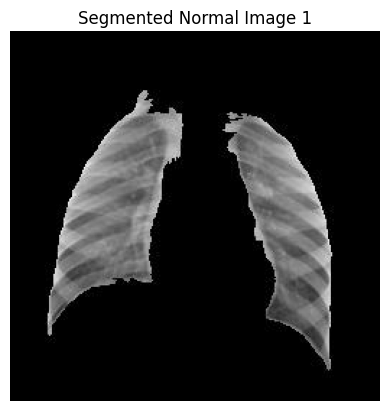

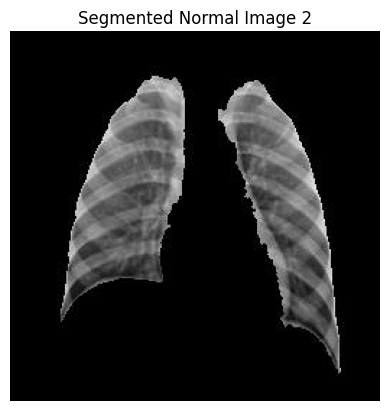

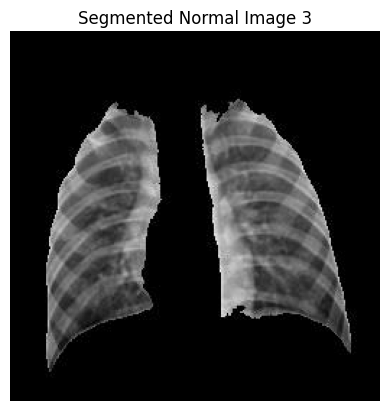

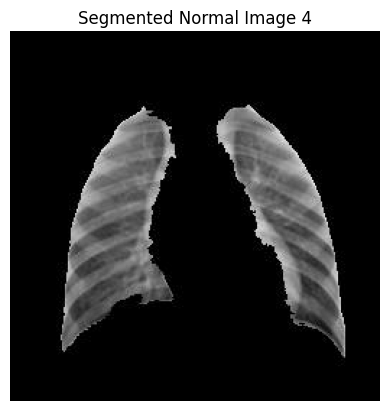

In [ ]:


# Set the directory path for segmented normal images
segmented_normal_dir = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/NORMAL_SEGMENTED/"

# Get a list of file names in the segmented normal directory
segmented_normal_files = os.listdir(segmented_normal_dir)

# Display four samples from the normal category in the training set
for i, file_name in enumerate(segmented_normal_files[:4]):
    segmented_path = os.path.join(segmented_normal_dir, file_name)
    segmented_image = io.imread(segmented_path)
    plt.figure()
    plt.imshow(img_as_ubyte(segmented_image), cmap='gray')
    plt.axis('off')
    plt.title(f'Segmented Normal Image {i + 1}')


In [ ]:

# Set the directory path for segmented normal images
segmented_pneumonia_dir = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/"


Text(0.5, 1.0, 'Segmented Pneumonia Image 1')

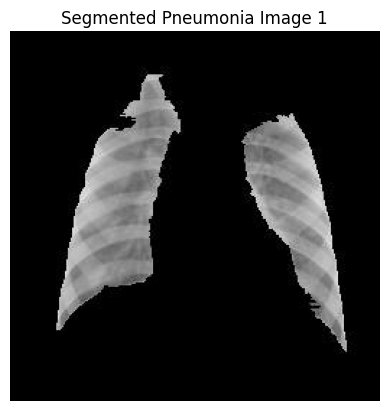

In [ ]:
filename1 =  "person1_bacteria_2.jpeg"
segmented_path1 = os.path.join(segmented_pneumonia_dir, filename1)
segmented_image = io.imread(segmented_path1)
plt.figure()
plt.imshow(img_as_ubyte(segmented_image), cmap='gray')
plt.axis('off')
plt.title(f'Segmented Pneumonia Image 1')

Text(0.5, 1.0, 'Segmented Pneumonia Image 2')

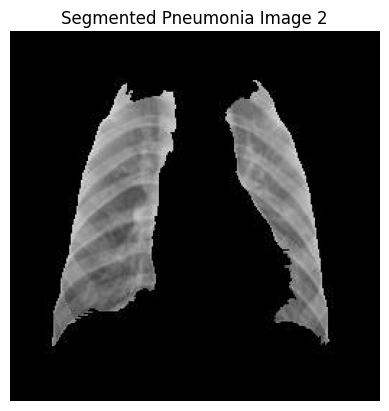

In [ ]:

filename2 =  "person1941_bacteria_4863.jpeg"
segmented_path2 = os.path.join(segmented_pneumonia_dir, filename2)
segmented_image = io.imread(segmented_path2)
plt.figure()
plt.imshow(img_as_ubyte(segmented_image), cmap='gray')
plt.axis('off')
plt.title(f'Segmented Pneumonia Image 2')

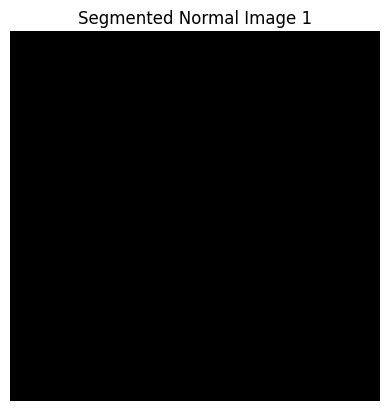

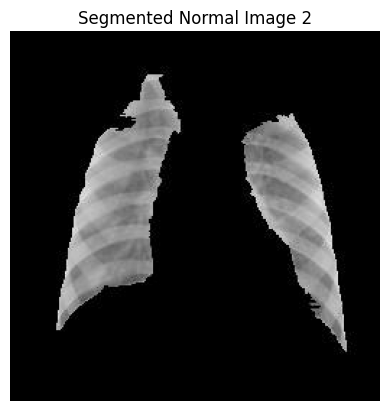

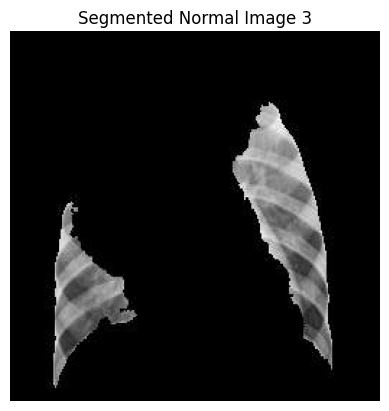

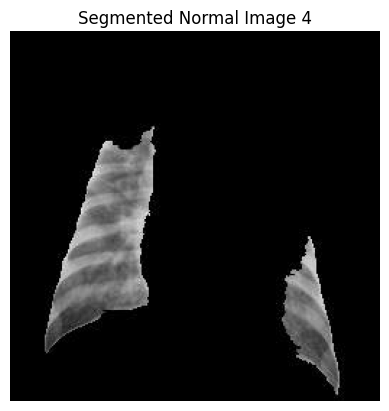

In [ ]:


# Set the directory path for segmented normal images
segmented_pneumonia_dir = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia/train_SEGMENTED/PNEUMONIA_SEGMENTED/"

# Get a list of file names in the segmented normal directory
segmented_pneumonia_files = os.listdir(segmented_pneumonia_dir)

# Display four samples from the normal category in the training set
for i, file_name in enumerate(segmented_pneumonia_files[:4]):
    segmented_path = os.path.join(segmented_pneumonia_dir, file_name)
    segmented_image = io.imread(segmented_path)
    plt.figure()
    plt.imshow(img_as_ubyte(segmented_image), cmap='gray')
    plt.axis('off')
    plt.title(f'Segmented Normal Image {i + 1}')


### poor segmentations with the pneumonia train dataset above contributed to a model with lower accuracy below. This could be a result of the pre-trained model not being trained specifically on this dataset.

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Task 10:

Repeat the previous experiments (Task5, Task 7, and Task 8) but now using lung segmentation. Compare the results and grad-cam of the new model with the model trained previously with the dataset without segmentation. If you do not write these comments, points will be deducted.


### repeating task 5

In [ ]:
# YOUR CODE HERE
root_dir = "/content/drive/MyDrive/Colab Notebooks/XRay_chest_pneumonia"
trainSEG_dir = f"{root_dir}/train_SEGMENTED"
valSEG_dir = f"{root_dir}/val_SEGMENTED"
testSEG_dir = f"{root_dir}/test_SEGMENTED"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-10, 10)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Create datasets and data loaders
trainSEG_data = datasets.ImageFolder(trainSEG_dir, transform=transform)
valSEG_data = datasets.ImageFolder(valSEG_dir, transform=transform)
testSEG_data = datasets.ImageFolder(testSEG_dir, transform=transform)

trainSEG_loader = DataLoader(trainSEG_data, batch_size=64, shuffle=True)
valSEG_loader = DataLoader(valSEG_data, batch_size=64, shuffle=True)
testSEG_loader = DataLoader(testSEG_data, batch_size=64, shuffle=False)

In [ ]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:

# Initialize the model, optimizer, and criterion
model = SimpleCNN().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc

In [ ]:
# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc

In [ ]:
# Compute class weights
normal_count = len(os.listdir(os.path.join(trainSEG_dir, "NORMAL_SEGMENTED")))
pneumonia_count = len(os.listdir(os.path.join(trainSEG_dir, "PNEUMONIA_SEGMENTED")))
total_count = normal_count + pneumonia_count
class_weights = torch.tensor([total_count / normal_count, total_count / pneumonia_count])

# Use the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights.to('cuda'))

In [ ]:
# Train and validate the model
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, trainSEG_loader, criterion, optimizer, 'cuda')
    val_loss, val_acc = validate(model, valSEG_loader, criterion, 'cuda')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10, Train Loss: 1.2061, Train Acc: 0.6315, Val Loss: 0.9341, Val Acc: 0.6250
Epoch 2/10, Train Loss: 0.3651, Train Acc: 0.8255, Val Loss: 1.7145, Val Acc: 0.5000
Epoch 3/10, Train Loss: 0.3305, Train Acc: 0.8492, Val Loss: 1.3936, Val Acc: 0.6250
Epoch 4/10, Train Loss: 0.3048, Train Acc: 0.8705, Val Loss: 1.0031, Val Acc: 0.6250
Epoch 5/10, Train Loss: 0.2728, Train Acc: 0.8861, Val Loss: 1.5825, Val Acc: 0.5625
Epoch 6/10, Train Loss: 0.2689, Train Acc: 0.8901, Val Loss: 0.8610, Val Acc: 0.8125
Epoch 7/10, Train Loss: 0.2499, Train Acc: 0.9033, Val Loss: 0.9791, Val Acc: 0.6250
Epoch 8/10, Train Loss: 0.2456, Train Acc: 0.9061, Val Loss: 1.1016, Val Acc: 0.6875
Epoch 9/10, Train Loss: 0.2494, Train Acc: 0.9023, Val Loss: 0.7991, Val Acc: 0.6875
Epoch 10/10, Train Loss: 0.2389, Train Acc: 0.9074, Val Loss: 0.9365, Val Acc: 0.8125


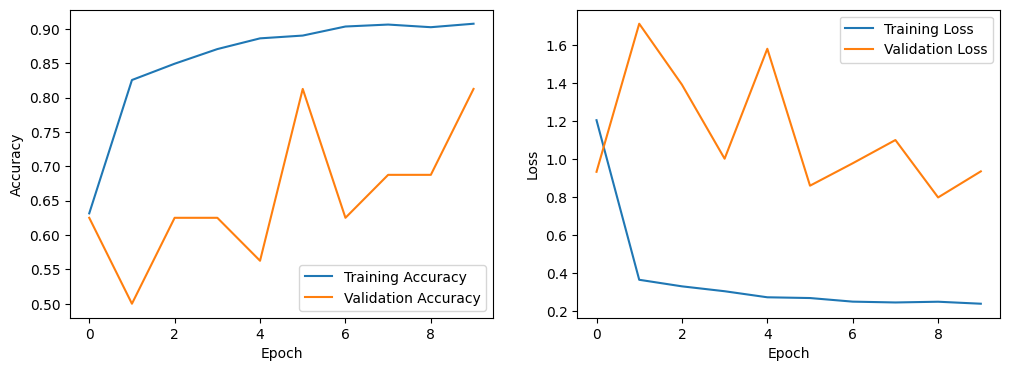

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([acc.item() for acc in train_accuracies], label='Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Calculate recall, precision, accuracy, and F1-score
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in testSEG_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print(f"Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}, F1-score: {f1_score:.4f}")

Recall: 0.9282, Precision: 0.7686, Accuracy: 0.7804, F1-score: 0.8409


I do believe the quality of the segmentations affected the model's accuracy (it is lower compared to the model without segmentation). Specifically in the pneumonia train dataset, some of the segmentations were cutoff too much or completely dark. Also, I had to implement a try-except block for the pneumonia train dataset because U-net threw a convolution error for some images in the pneumonia (train dataset), so images that could not be segmented had to be left out. The segmentation model only had troubles for the pneumonia train dataset, but not for the normal train dataset, or the correponding normal/pneumonia in the validation or test subfolders (I could reuse the same code block just changing the paths, and didn't need try-except).

I also believe segmentations could have been better if the U-Net model was trained specifically on this dataset, and not just using pre-trained U-Net. Maybe some fine-tuning would have been helpful.

###Results without segmentation
Recall: 0.9615, Precision: 0.8315, Accuracy: 0.8542, F1-score: 0.8918

###Results with segmentation
Recall: 0.9282, Precision: 0.7686, Accuracy: 0.7804, F1-score: 0.8409

### repeating tasks 7 and 8 (different implementation from earlier)

In [ ]:
# Grad-CAM
gradcam = GradCAM(model, model.conv2)

In [ ]:
# class labels
class_labels = ['Normal', 'Pneumonia']


test_loader = DataLoader(testSEG_data, batch_size=1, shuffle=False)

In [ ]:
#  lists (store category sample indices )
true_positive = []
false_positive = []
true_negative = []
false_negative = []

In [ ]:
# determine categoryof each samply by looping over the test dataset
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    _, predicted = torch.max(output.data, 1)
    if predicted == labels:
        if predicted == 1:
            true_positive.append(i)
        else:
            true_negative.append(i)
    else:
        if predicted == 1:
            false_positive.append(i)
        else:
            false_negative.append(i)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
#display the Grad-CAM image
def display_gradcam(sample_index, category):
    # get the image and label
    image, label = testSEG_data[sample_index]
    image = image.unsqueeze(0).to(device)

    # pass the image through the model to get the output
    output = model(image.to(device))

    # determine the predicted class label for the image
    _, predicted = torch.max(output.data, 1)
    predicted_label = class_labels[predicted.cpu().item()]

    # print the predicted label, original label, and category
    print(f"Predicted label: {predicted_label}, Original label: {class_labels[label]}, Category: {category}")

    # generate the Grad-CAM heatmap for the predicted class label
    cam = gradcam(image.to(device))

    # convert the tensor to a numpy array with a dtype of np.uint8
    cam = cam[0].squeeze().cpu().numpy()  # move tensor to CPU and remove the extra dimensions
    cam = np.uint8(255 * cam)

    # apply the colormap to the heatmap
    colormap = cv2.COLORMAP_JET
    heatmap = cv2.applyColorMap(cam, colormap)

    # map the heatmap to the original image and display the Grad-CAM image
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    images_np = image.permute(0, 2, 3, 1).cpu().numpy()
    result = heatmap * images_np + (1 - images_np) * 255
    result = np.uint8(result)

    # plot the original image with the heatmap overlaid
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(image[0].permute(1, 2, 0).cpu())
    ax[0].set_title(f"Original Image ({class_labels[label]})")
    ax[0].axis("off")
    ax[1].imshow(result[0])
    ax[1].set_title(f"Heatmap")
    ax[1].axis("off")
    fig.suptitle(category)
    plt.show()

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Predicted label: Pneumonia, Original label: Pneumonia, Category: True Positive


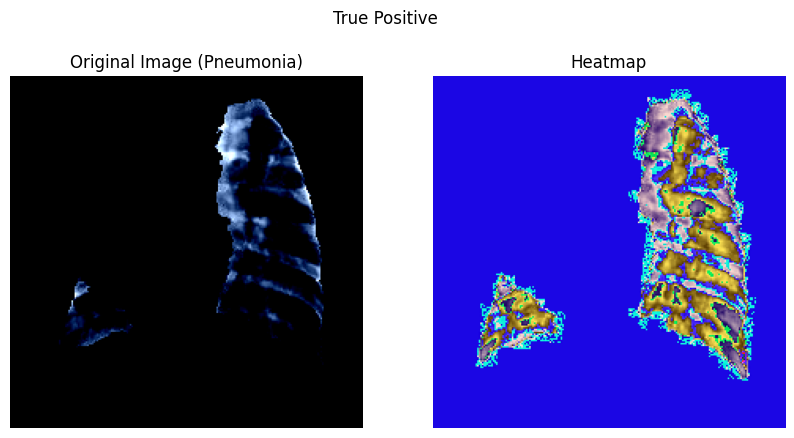

Predicted label: Pneumonia, Original label: Normal, Category: False Positive


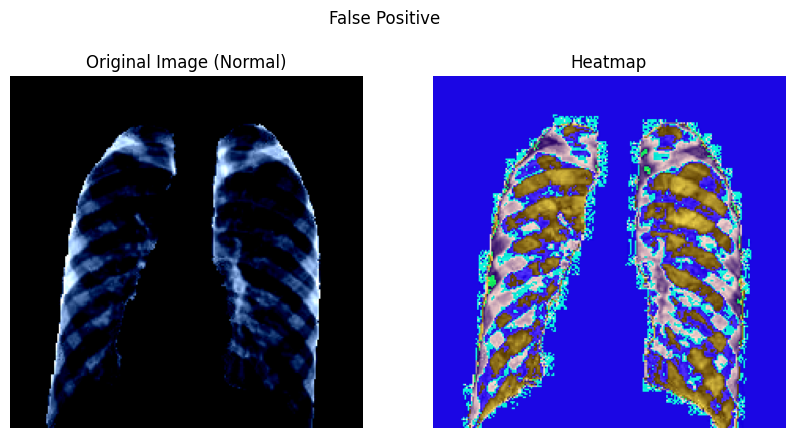

Predicted label: Pneumonia, Original label: Normal, Category: True Negative


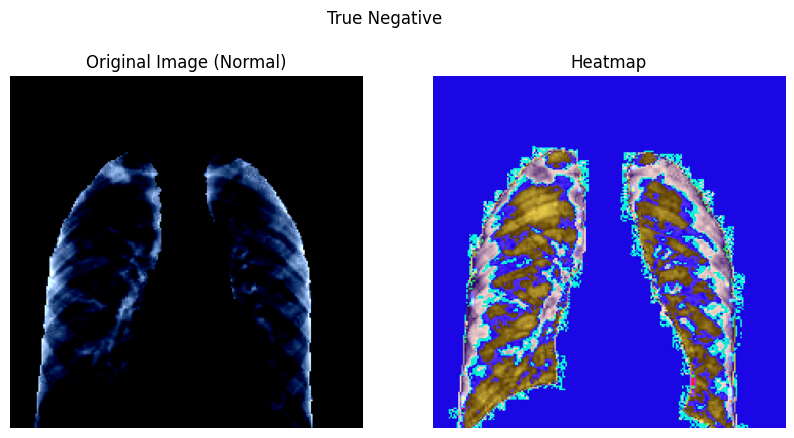

Predicted label: Normal, Original label: Pneumonia, Category: False Negative


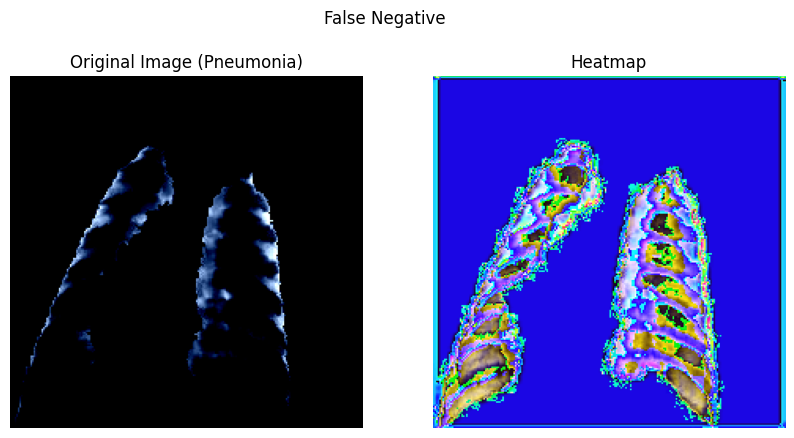

In [ ]:
# visualize true positive sample
tp_index = true_positive[0]
display_gradcam(tp_index, 'True Positive')

# visualize one false positive sample
fp_index = false_positive[1]
display_gradcam(fp_index, 'False Positive')

# visualize negative sample
tn_index = true_negative[2]
display_gradcam(tn_index, 'True Negative')

# visualize negative sample
fn_index = false_negative[3]
display_gradcam(fn_index, 'False Negative')

Predicted label: Pneumonia, Original label: Pneumonia, Category: True Positive


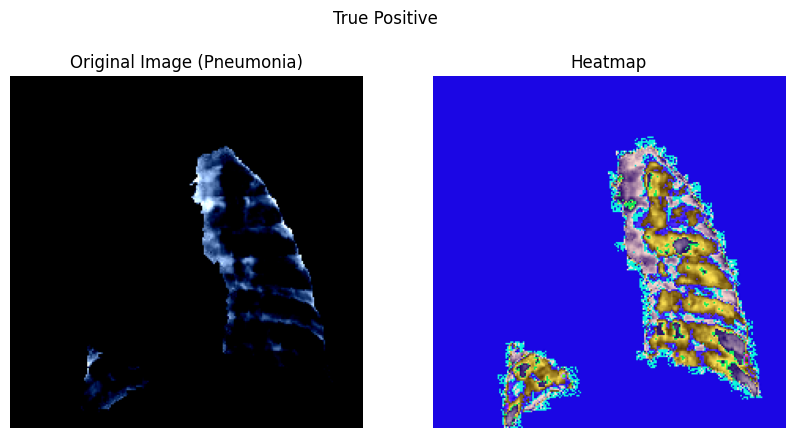

Predicted label: Pneumonia, Original label: Normal, Category: False Positive


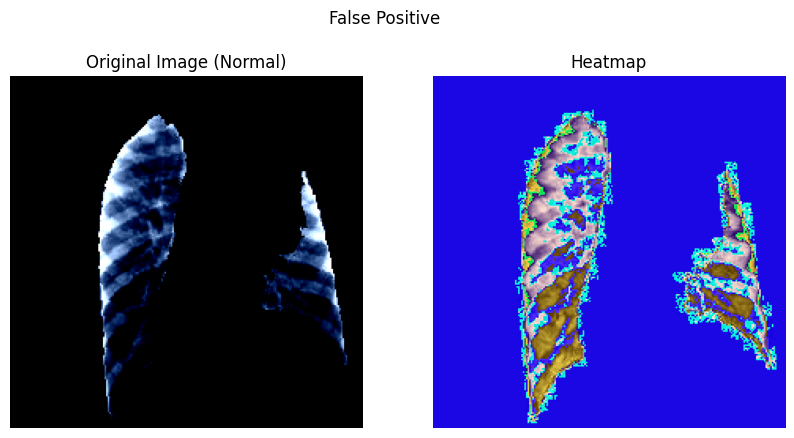

Predicted label: Pneumonia, Original label: Normal, Category: True Negative


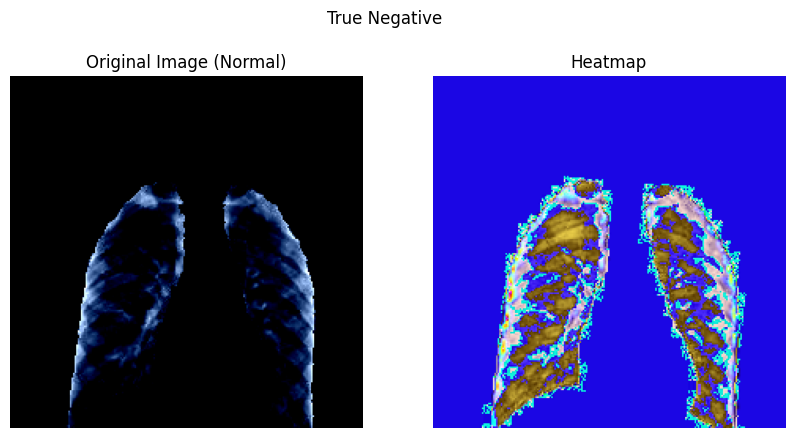

Predicted label: Normal, Original label: Pneumonia, Category: False Negative


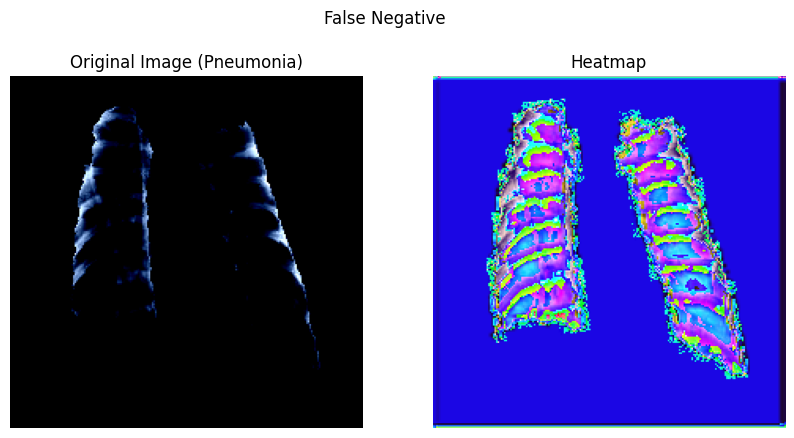

In [ ]:
# visualize one true positive sample
tp_index = true_positive[0]
display_gradcam(tp_index, 'True Positive')

# visualize one false positive sample
fp_index = false_positive[1]
display_gradcam(fp_index, 'False Positive')

# visualize one true negative sample
tn_index = true_negative[2]
display_gradcam(tn_index, 'True Negative')

# visualize one false negative sample
fn_index = false_negative[3]
display_gradcam(fn_index, 'False Negative')

###Results without segmentation
Recall: 0.9615, Precision: 0.8315, Accuracy: 0.8542, F1-score: 0.8918

###Results with segmentation
Recall: 0.9282, Precision: 0.7686, Accuracy: 0.7804, F1-score: 0.8409

Regarding Grad-CAM visualizations, a comparison between the two models can help understand how each model focuses on different regions of the images to make predictions. The model trained on the non-segmented dataset may rely more on features present in the background and surrounding areas, as it has access to the entire image. In contrast, the model trained on the segmented dataset will likely focus more on the lung regions, as the segmentation process has removed most of the background and irrelevant areas.

However, a higher focus on lung regions does not necessarily guarantee better performance, as seen in the metrics above. The context provided by the background and surrounding areas in the non-segmented images might contain valuable information that helps the model achieve better results in this specific case.

Maybe, while segmentation can be helpful in some cases by isolating the region of interest and reducing the impact of background noise, it may not always lead to improved performance.


> Use TSNE for visualization of embeddings obtained using model to see if embeddings form seperate clusters. Feel free to use any library.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Function to extract embeddings
def extract_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for inputs, batch_labels in loader:
            inputs = inputs.to('cuda')
            outputs = model(inputs)
            embeddings.extend(outputs.cpu().numpy())
            labels.extend(batch_labels.numpy())

    return np.array(embeddings), np.array(labels)

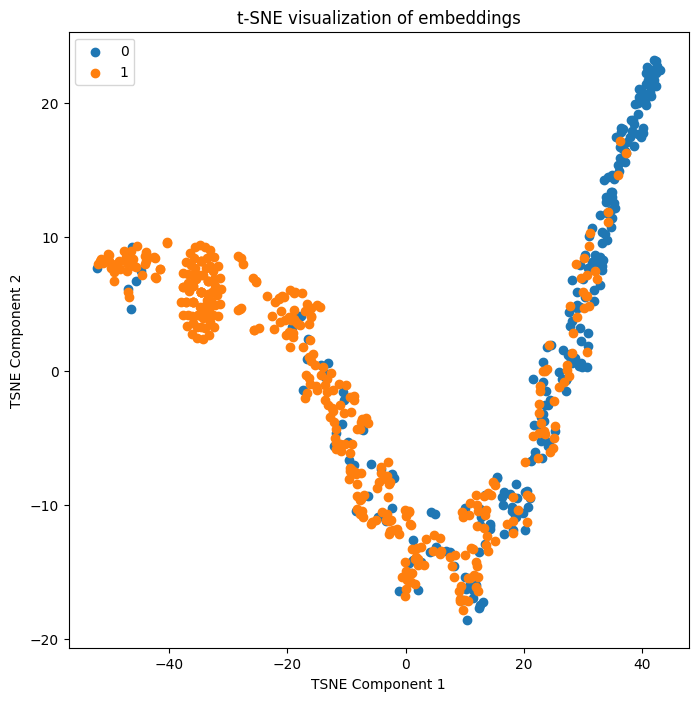

In [ ]:
# Extract embeddings
embeddings, labels = extract_embeddings(model, testSEG_loader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=label)

plt.legend()
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE visualization of embeddings')
plt.show()
